<a href="https://colab.research.google.com/github/deepakgowtham/EVA4/blob/master/Week6/Session_6_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [2]:
use_cuda = torch.cuda.is_available()

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
SEED=1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

torch.manual_seed(1)
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-13.0, 13.0), fill=(1,)),
                                       #transforms.RandomResizedCrop(size=28, scale=(0.75, 0.8)),
                                       transforms.
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


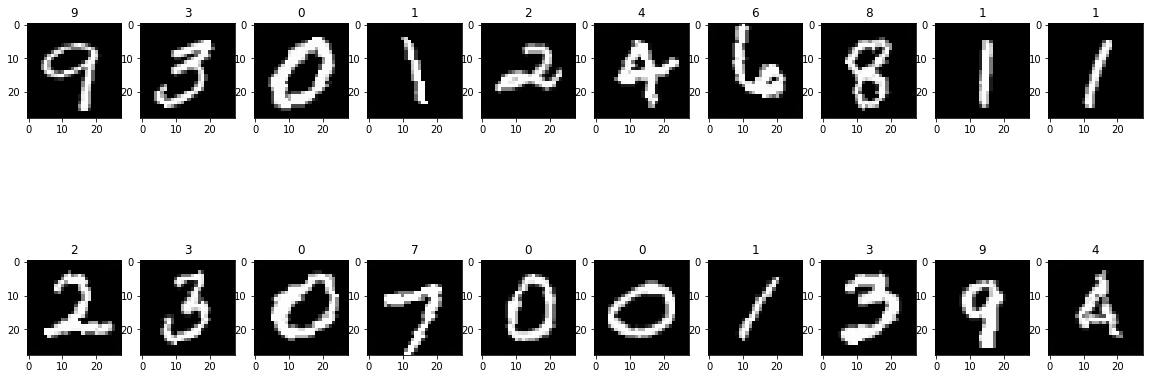

In [3]:
images, label = next(iter(train_loader))
fig = plt.figure(figsize=(20, 8))
for i in range(20):
  ax=fig.add_subplot(2, 10, i+1)
  img= np.squeeze(images[i].numpy())
  ax.imshow(img, cmap='gray')
  ax.set_title(str(label[i].item()))



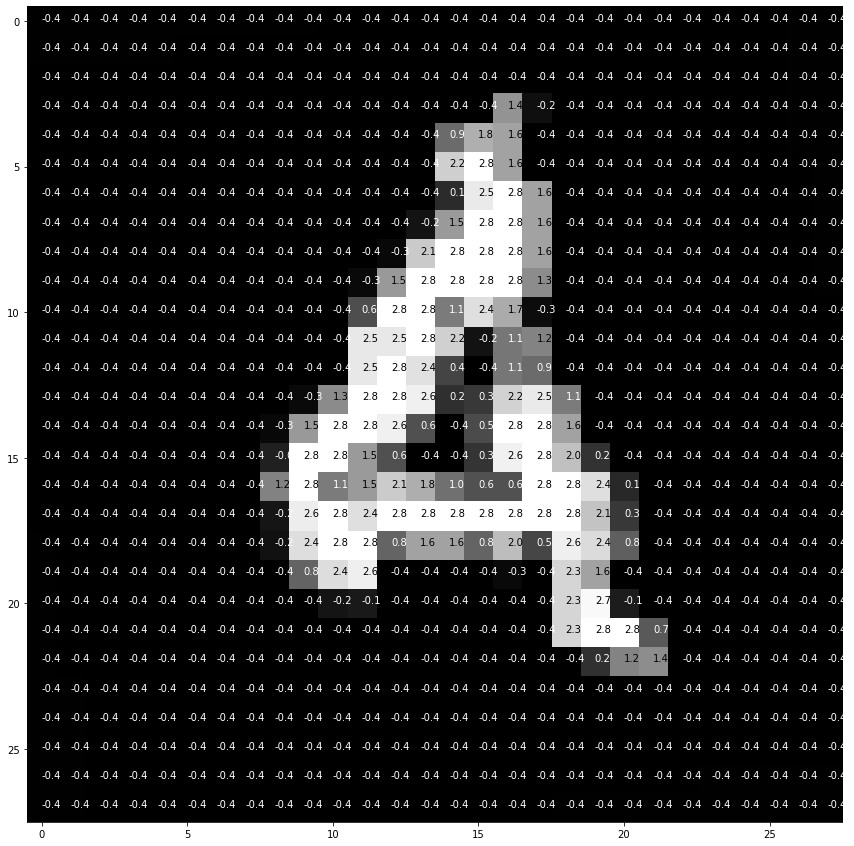

In [4]:
width, height = img.shape
fig= plt.figure(figsize=(15,15))
ax= fig.add_subplot(1,1,1)
ax.imshow(img, cmap='gray')
thresh =img.max()/2.5
for x in range(width):
  for y in range(height):
    val= round(img[x][y],1) if img[x][y] !=0 else 0
    ax.annotate(str(val), xy= (y,x),
                color='white' if val< thresh else 'black')

In [0]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

In [0]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.conv_block1= nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(),#output size 26
        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3),  bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(), #output size 24
    )
    self.trans_block1= nn.Sequential(
        nn.MaxPool2d(2,2),#output size 14
        
    )
    self.conv_block2= nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(),  #output size 10

        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(), #output size 8

       

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU() #output size 6
    )

    self.trans_block2= nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1,1))
    )

  def forward(self, x):
    x= self.conv_block1(x)
    x= self.trans_block1(x)
    x= self.conv_block2(x)
    x= self.trans_block2(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)


In [37]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net2().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8            [-1, 8, 10, 10]             576
       BatchNorm2d-9            [-1, 8, 10, 10]              16
             ReLU-10            [-1, 8, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           1,152
      BatchNorm2d-12             [-1, 16, 8, 8]              32
             ReLU-13             [-1, 16, 8, 8]               0
           Conv2d-14             [-1, 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses_1 = []
train_acc = []
test_acc_1 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_1.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_1.append(100. * correct / len(test_loader.dataset))

In [39]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = OneCycleLR(optimizer,max_lr=0.4,total_steps=40)

for epoch in range(1, 41):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1 Learning_Rate [0.016000000000000014]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.038953617215156555 Batch_id=937 Accuracy=90.66: 100%|██████████| 938/938 [00:17<00:00, 53.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0621, Accuracy: 9804/10000 (98.04%)

Epoch: 2 Learning_Rate [0.023777349066016473]


Loss=0.059532806277275085 Batch_id=937 Accuracy=97.37: 100%|██████████| 938/938 [00:17<00:00, 54.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9865/10000 (98.65%)

Epoch: 3 Learning_Rate [0.04647932169641322]


Loss=0.0475417822599411 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:16<00:00, 55.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9876/10000 (98.76%)

Epoch: 4 Learning_Rate [0.08226673908250526]


Loss=0.004969239234924316 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:17<00:00, 55.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9888/10000 (98.88%)

Epoch: 5 Learning_Rate [0.1282403175036378]


Loss=0.1808197945356369 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:16<00:00, 57.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0926, Accuracy: 9715/10000 (97.15%)

Epoch: 6 Learning_Rate [0.18067555105152924]


Loss=0.11662614345550537 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:16<00:00, 56.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9902/10000 (99.02%)

Epoch: 7 Learning_Rate [0.23532444894847074]


Loss=0.07645554840564728 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:16<00:00, 57.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9892/10000 (98.92%)

Epoch: 8 Learning_Rate [0.2877596824963622]


Loss=0.01368725299835205 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:16<00:00, 57.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9851/10000 (98.51%)

Epoch: 9 Learning_Rate [0.3337332609174947]


Loss=0.009203985333442688 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:17<00:00, 54.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9933/10000 (99.33%)

Epoch: 10 Learning_Rate [0.3695206783035868]


Loss=0.0015273094177246094 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:16<00:00, 67.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9913/10000 (99.13%)

Epoch: 11 Learning_Rate [0.3922226509339835]


Loss=0.037312284111976624 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:15<00:00, 69.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9891/10000 (98.91%)

Epoch: 12 Learning_Rate [0.4]


Loss=0.03340354561805725 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:16<00:00, 58.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9922/10000 (99.22%)

Epoch: 13 Learning_Rate [0.3987424470088807]


Loss=0.023626863956451416 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:15<00:00, 59.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9926/10000 (99.26%)

Epoch: 14 Learning_Rate [0.39498560249403497]


Loss=0.1372353583574295 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:15<00:00, 59.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9912/10000 (99.12%)

Epoch: 15 Learning_Rate [0.38877671095500926]


Loss=0.0046906620264053345 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:15<00:00, 59.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

Epoch: 16 Learning_Rate [0.38019385280538953]


Loss=0.012551069259643555 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:16<00:00, 58.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9913/10000 (99.13%)

Epoch: 17 Learning_Rate [0.36934496246629744]


Loss=0.1380268633365631 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:16<00:00, 57.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

Epoch: 18 Learning_Rate [0.35636647102842]


Loss=0.008658096194267273 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:16<00:00, 58.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9909/10000 (99.09%)

Epoch: 19 Learning_Rate [0.34142159055188454]


Loss=0.0004052072763442993 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:16<00:00, 58.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9911/10000 (99.11%)

Epoch: 20 Learning_Rate [0.3246982615799052]


Loss=0.012349620461463928 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:15<00:00, 59.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

Epoch: 21 Learning_Rate [0.30640678967740614]


Loss=0.002180814743041992 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:16<00:00, 58.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)

Epoch: 22 Learning_Rate [0.28677720071652035]


Loss=0.0016289353370666504 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:16<00:00, 57.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

Epoch: 23 Learning_Rate [0.2660563481677839]


Loss=0.04905666410923004 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:15<00:00, 59.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

Epoch: 24 Learning_Rate [0.24450480877451572]


Loss=0.0220346599817276 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:15<00:00, 59.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

Epoch: 25 Learning_Rate [0.2223936056490807]


Loss=0.0044727325439453125 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:15<00:00, 60.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.39%)

Epoch: 26 Learning_Rate [0.2000008]


Loss=0.0004456937313079834 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:16<00:00, 56.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

Epoch: 27 Learning_Rate [0.1776079943509193]


Loss=0.0033495724201202393 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:15<00:00, 59.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

Epoch: 28 Learning_Rate [0.1554967912254843]


Loss=0.0016953051090240479 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:15<00:00, 60.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

Epoch: 29 Learning_Rate [0.1339452518322162]


Loss=0.005759581923484802 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:16<00:00, 58.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)

Epoch: 30 Learning_Rate [0.11322439928347969]


Loss=0.011388003826141357 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:15<00:00, 59.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

Epoch: 31 Learning_Rate [0.09359481032259394]


Loss=0.00019308924674987793 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:16<00:00, 56.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9955/10000 (99.55%)

Epoch: 32 Learning_Rate [0.0753033384200948]


Loss=0.003900960087776184 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [00:16<00:00, 56.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9955/10000 (99.55%)

Epoch: 33 Learning_Rate [0.05858000944811546]


Loss=0.03111100196838379 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:16<00:00, 57.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 9955/10000 (99.55%)

Epoch: 34 Learning_Rate [0.04363512897158001]


Loss=0.0009705126285552979 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:16<00:00, 57.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 9958/10000 (99.58%)

Epoch: 35 Learning_Rate [0.030656637533702562]


Loss=0.008349359035491943 Batch_id=937 Accuracy=99.50: 100%|██████████| 938/938 [00:16<00:00, 57.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 9953/10000 (99.53%)

Epoch: 36 Learning_Rate [0.019807747194610516]


Loss=0.03591644763946533 Batch_id=937 Accuracy=99.50: 100%|██████████| 938/938 [00:16<00:00, 55.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9955/10000 (99.55%)

Epoch: 37 Learning_Rate [0.011224889044990732]


Loss=0.0022258013486862183 Batch_id=937 Accuracy=99.53: 100%|██████████| 938/938 [00:16<00:00, 55.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 9954/10000 (99.54%)

Epoch: 38 Learning_Rate [0.005015997505965022]


Loss=0.0006797909736633301 Batch_id=937 Accuracy=99.61: 100%|██████████| 938/938 [00:16<00:00, 56.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 9953/10000 (99.53%)

Epoch: 39 Learning_Rate [0.001259152991119394]


Loss=0.02362935245037079 Batch_id=937 Accuracy=99.56: 100%|██████████| 938/938 [00:16<00:00, 55.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 9956/10000 (99.56%)

Epoch: 40 Learning_Rate [1.6e-06]


Loss=0.0226476788520813 Batch_id=937 Accuracy=99.55: 100%|██████████| 938/938 [00:16<00:00, 57.19it/s]



Test set: Average loss: 0.0140, Accuracy: 9957/10000 (99.57%)



In [0]:
model=None

## With L1 Regularisation

In [0]:
from tqdm import tqdm

train_losses = []
test_losses_l1 = []
train_acc = []
test_acc_l1 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  criterion= nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        reg_loss += torch.sum(abs(param))

    classify_loss  = criterion(y_pred, target)
    factor = 0.0005
    loss = classify_loss + factor * reg_loss

    train_losses.append(loss)

   

     #Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            

            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1.append(100. * correct / len(test_loader.dataset))

In [8]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = OneCycleLR(optimizer,max_lr=0.4,total_steps=40)

for epoch in range(1, 41):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1 Learning_Rate [0.016000000000000014]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.36631613969802856 Batch_id=937 Accuracy=90.75: 100%|██████████| 938/938 [00:17<00:00, 54.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1133, Accuracy: 9672/10000 (96.72%)

Epoch: 2 Learning_Rate [0.023777349066016473]


Loss=0.337150901556015 Batch_id=937 Accuracy=96.41: 100%|██████████| 938/938 [00:16<00:00, 55.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1298, Accuracy: 9597/10000 (95.97%)

Epoch: 3 Learning_Rate [0.04647932169641322]


Loss=0.5566918253898621 Batch_id=937 Accuracy=96.07: 100%|██████████| 938/938 [00:17<00:00, 53.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1508, Accuracy: 9531/10000 (95.31%)

Epoch: 4 Learning_Rate [0.08226673908250526]


Loss=0.33831819891929626 Batch_id=937 Accuracy=95.98: 100%|██████████| 938/938 [00:17<00:00, 54.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1010, Accuracy: 9681/10000 (96.81%)

Epoch: 5 Learning_Rate [0.1282403175036378]


Loss=0.5600569248199463 Batch_id=937 Accuracy=95.83: 100%|██████████| 938/938 [00:17<00:00, 55.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1059, Accuracy: 9673/10000 (96.73%)

Epoch: 6 Learning_Rate [0.18067555105152924]


Loss=0.45862510800361633 Batch_id=937 Accuracy=95.50: 100%|██████████| 938/938 [00:17<00:00, 52.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1772, Accuracy: 9451/10000 (94.51%)

Epoch: 7 Learning_Rate [0.23532444894847074]


Loss=0.35263198614120483 Batch_id=937 Accuracy=95.62: 100%|██████████| 938/938 [00:17<00:00, 53.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3536, Accuracy: 9037/10000 (90.37%)

Epoch: 8 Learning_Rate [0.2877596824963622]


Loss=0.485370934009552 Batch_id=937 Accuracy=95.42: 100%|██████████| 938/938 [00:17<00:00, 54.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1784, Accuracy: 9442/10000 (94.42%)

Epoch: 9 Learning_Rate [0.3337332609174947]


Loss=0.6622474193572998 Batch_id=937 Accuracy=95.41: 100%|██████████| 938/938 [00:17<00:00, 53.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1634, Accuracy: 9531/10000 (95.31%)

Epoch: 10 Learning_Rate [0.3695206783035868]


Loss=0.4274837076663971 Batch_id=937 Accuracy=95.26: 100%|██████████| 938/938 [00:17<00:00, 54.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1022, Accuracy: 9663/10000 (96.63%)

Epoch: 11 Learning_Rate [0.3922226509339835]


Loss=0.43065541982650757 Batch_id=937 Accuracy=95.41: 100%|██████████| 938/938 [00:17<00:00, 53.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3273, Accuracy: 8939/10000 (89.39%)

Epoch: 12 Learning_Rate [0.4]


Loss=0.5935755968093872 Batch_id=937 Accuracy=95.25: 100%|██████████| 938/938 [00:16<00:00, 55.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3704, Accuracy: 8737/10000 (87.37%)

Epoch: 13 Learning_Rate [0.3987424470088807]


Loss=0.639527440071106 Batch_id=937 Accuracy=95.42: 100%|██████████| 938/938 [00:17<00:00, 53.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1671, Accuracy: 9437/10000 (94.37%)

Epoch: 14 Learning_Rate [0.39498560249403497]


Loss=0.46413636207580566 Batch_id=937 Accuracy=95.22: 100%|██████████| 938/938 [00:17<00:00, 53.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1393, Accuracy: 9576/10000 (95.76%)

Epoch: 15 Learning_Rate [0.38877671095500926]


Loss=0.3180496394634247 Batch_id=937 Accuracy=95.33: 100%|██████████| 938/938 [00:17<00:00, 63.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2760, Accuracy: 9155/10000 (91.55%)

Epoch: 16 Learning_Rate [0.38019385280538953]


Loss=0.42350393533706665 Batch_id=937 Accuracy=95.45: 100%|██████████| 938/938 [00:17<00:00, 53.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1581, Accuracy: 9458/10000 (94.58%)

Epoch: 17 Learning_Rate [0.36934496246629744]


Loss=0.4136301577091217 Batch_id=937 Accuracy=95.35: 100%|██████████| 938/938 [00:18<00:00, 51.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4246, Accuracy: 8679/10000 (86.79%)

Epoch: 18 Learning_Rate [0.35636647102842]


Loss=0.3223349452018738 Batch_id=937 Accuracy=95.43: 100%|██████████| 938/938 [00:18<00:00, 51.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3724, Accuracy: 8877/10000 (88.77%)

Epoch: 19 Learning_Rate [0.34142159055188454]


Loss=0.4185989797115326 Batch_id=937 Accuracy=95.53: 100%|██████████| 938/938 [00:17<00:00, 52.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1861, Accuracy: 9460/10000 (94.60%)

Epoch: 20 Learning_Rate [0.3246982615799052]


Loss=0.31389740109443665 Batch_id=937 Accuracy=95.58: 100%|██████████| 938/938 [00:17<00:00, 54.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1373, Accuracy: 9564/10000 (95.64%)

Epoch: 21 Learning_Rate [0.30640678967740614]


Loss=0.32907018065452576 Batch_id=937 Accuracy=95.58: 100%|██████████| 938/938 [00:17<00:00, 55.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3207, Accuracy: 8919/10000 (89.19%)

Epoch: 22 Learning_Rate [0.28677720071652035]


Loss=0.4832634925842285 Batch_id=937 Accuracy=95.56: 100%|██████████| 938/938 [00:17<00:00, 52.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1257, Accuracy: 9626/10000 (96.26%)

Epoch: 23 Learning_Rate [0.2660563481677839]


Loss=0.5051668882369995 Batch_id=937 Accuracy=95.66: 100%|██████████| 938/938 [00:17<00:00, 53.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3760, Accuracy: 8825/10000 (88.25%)

Epoch: 24 Learning_Rate [0.24450480877451572]


Loss=0.5649822950363159 Batch_id=937 Accuracy=95.74: 100%|██████████| 938/938 [00:17<00:00, 54.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2394, Accuracy: 9275/10000 (92.75%)

Epoch: 25 Learning_Rate [0.2223936056490807]


Loss=0.3904992938041687 Batch_id=937 Accuracy=95.86: 100%|██████████| 938/938 [00:17<00:00, 52.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1484, Accuracy: 9490/10000 (94.90%)

Epoch: 26 Learning_Rate [0.2000008]


Loss=0.6492270231246948 Batch_id=937 Accuracy=95.83: 100%|██████████| 938/938 [00:17<00:00, 54.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 1.7183, Accuracy: 6366/10000 (63.66%)

Epoch: 27 Learning_Rate [0.1776079943509193]


Loss=0.28964632749557495 Batch_id=937 Accuracy=96.05: 100%|██████████| 938/938 [00:17<00:00, 54.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1153, Accuracy: 9646/10000 (96.46%)

Epoch: 28 Learning_Rate [0.1554967912254843]


Loss=0.5325082540512085 Batch_id=937 Accuracy=95.99: 100%|██████████| 938/938 [00:17<00:00, 53.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2171, Accuracy: 9262/10000 (92.62%)

Epoch: 29 Learning_Rate [0.1339452518322162]


Loss=0.2675696611404419 Batch_id=937 Accuracy=96.07: 100%|██████████| 938/938 [00:17<00:00, 54.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4365, Accuracy: 8562/10000 (85.62%)

Epoch: 30 Learning_Rate [0.11322439928347969]


Loss=0.3583986759185791 Batch_id=937 Accuracy=96.25: 100%|██████████| 938/938 [00:17<00:00, 53.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0988, Accuracy: 9701/10000 (97.01%)

Epoch: 31 Learning_Rate [0.09359481032259394]


Loss=0.28700846433639526 Batch_id=937 Accuracy=96.49: 100%|██████████| 938/938 [00:17<00:00, 62.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1107, Accuracy: 9650/10000 (96.50%)

Epoch: 32 Learning_Rate [0.0753033384200948]


Loss=0.45245224237442017 Batch_id=937 Accuracy=96.48: 100%|██████████| 938/938 [00:17<00:00, 53.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0883, Accuracy: 9732/10000 (97.32%)

Epoch: 33 Learning_Rate [0.05858000944811546]


Loss=0.21899104118347168 Batch_id=937 Accuracy=96.59: 100%|██████████| 938/938 [00:17<00:00, 54.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1332, Accuracy: 9596/10000 (95.96%)

Epoch: 34 Learning_Rate [0.04363512897158001]


Loss=0.3936748504638672 Batch_id=937 Accuracy=96.91: 100%|██████████| 938/938 [00:17<00:00, 53.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0637, Accuracy: 9791/10000 (97.91%)

Epoch: 35 Learning_Rate [0.030656637533702562]


Loss=0.3553367257118225 Batch_id=937 Accuracy=97.18: 100%|██████████| 938/938 [00:17<00:00, 53.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9761/10000 (97.61%)

Epoch: 36 Learning_Rate [0.019807747194610516]


Loss=0.31043541431427 Batch_id=937 Accuracy=97.37: 100%|██████████| 938/938 [00:17<00:00, 53.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0741, Accuracy: 9776/10000 (97.76%)

Epoch: 37 Learning_Rate [0.011224889044990732]


Loss=0.19195345044136047 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:17<00:00, 54.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9861/10000 (98.61%)

Epoch: 38 Learning_Rate [0.005015997505965022]


Loss=0.15833017230033875 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:17<00:00, 53.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9897/10000 (98.97%)

Epoch: 39 Learning_Rate [0.001259152991119394]


Loss=0.1510835736989975 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:17<00:00, 53.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9904/10000 (99.04%)

Epoch: 40 Learning_Rate [1.6e-06]


Loss=0.19515812397003174 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:18<00:00, 51.89it/s]



Test set: Average loss: 0.0316, Accuracy: 9903/10000 (99.03%)



## With L2 Regularisation

In [0]:
model=None

In [0]:
from tqdm import tqdm

train_losses = []
test_losses_l2 = []
train_acc = []
test_acc_l2= []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l2.append(100. * correct / len(test_loader.dataset))

In [16]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1,weight_decay=0.001)
scheduler = OneCycleLR(optimizer,max_lr=0.4,total_steps=40)

for epoch in range(1, 41):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1 Learning_Rate [0.016000000000000014]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.14530052244663239 Batch_id=937 Accuracy=90.57: 100%|██████████| 938/938 [00:16<00:00, 56.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 9805/10000 (98.05%)

Epoch: 2 Learning_Rate [0.023777349066016473]


Loss=0.2577311098575592 Batch_id=937 Accuracy=97.12: 100%|██████████| 938/938 [00:17<00:00, 54.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0739, Accuracy: 9796/10000 (97.96%)

Epoch: 3 Learning_Rate [0.04647932169641322]


Loss=0.1353708654642105 Batch_id=937 Accuracy=96.91: 100%|██████████| 938/938 [00:16<00:00, 56.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9801/10000 (98.01%)

Epoch: 4 Learning_Rate [0.08226673908250526]


Loss=0.14495977759361267 Batch_id=937 Accuracy=96.81: 100%|██████████| 938/938 [00:16<00:00, 56.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0812, Accuracy: 9741/10000 (97.41%)

Epoch: 5 Learning_Rate [0.1282403175036378]


Loss=0.13473086059093475 Batch_id=937 Accuracy=96.66: 100%|██████████| 938/938 [00:16<00:00, 65.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1640, Accuracy: 9508/10000 (95.08%)

Epoch: 6 Learning_Rate [0.18067555105152924]


Loss=0.0864017903804779 Batch_id=937 Accuracy=96.55: 100%|██████████| 938/938 [00:16<00:00, 55.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2147, Accuracy: 9319/10000 (93.19%)

Epoch: 7 Learning_Rate [0.23532444894847074]


Loss=0.16831955313682556 Batch_id=937 Accuracy=96.39: 100%|██████████| 938/938 [00:16<00:00, 57.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0870, Accuracy: 9746/10000 (97.46%)

Epoch: 8 Learning_Rate [0.2877596824963622]


Loss=0.0676540657877922 Batch_id=937 Accuracy=96.34: 100%|██████████| 938/938 [00:17<00:00, 53.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1033, Accuracy: 9657/10000 (96.57%)

Epoch: 9 Learning_Rate [0.3337332609174947]


Loss=0.09258939325809479 Batch_id=937 Accuracy=96.08: 100%|██████████| 938/938 [00:17<00:00, 53.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1628, Accuracy: 9454/10000 (94.54%)

Epoch: 10 Learning_Rate [0.3695206783035868]


Loss=0.06104234606027603 Batch_id=937 Accuracy=96.15: 100%|██████████| 938/938 [00:17<00:00, 54.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0786, Accuracy: 9774/10000 (97.74%)

Epoch: 11 Learning_Rate [0.3922226509339835]


Loss=0.10522300004959106 Batch_id=937 Accuracy=96.16: 100%|██████████| 938/938 [00:17<00:00, 53.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2635, Accuracy: 9104/10000 (91.04%)

Epoch: 12 Learning_Rate [0.4]


Loss=0.05540534853935242 Batch_id=937 Accuracy=96.05: 100%|██████████| 938/938 [00:17<00:00, 54.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 1.1133, Accuracy: 7130/10000 (71.30%)

Epoch: 13 Learning_Rate [0.3987424470088807]


Loss=0.048131100833415985 Batch_id=937 Accuracy=96.17: 100%|██████████| 938/938 [00:17<00:00, 54.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1097, Accuracy: 9642/10000 (96.42%)

Epoch: 14 Learning_Rate [0.39498560249403497]


Loss=0.07269134372472763 Batch_id=937 Accuracy=96.27: 100%|██████████| 938/938 [00:17<00:00, 54.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1318, Accuracy: 9637/10000 (96.37%)

Epoch: 15 Learning_Rate [0.38877671095500926]


Loss=0.38632360100746155 Batch_id=937 Accuracy=96.25: 100%|██████████| 938/938 [00:17<00:00, 54.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4311, Accuracy: 8635/10000 (86.35%)

Epoch: 16 Learning_Rate [0.38019385280538953]


Loss=0.11635396629571915 Batch_id=937 Accuracy=96.21: 100%|██████████| 938/938 [00:16<00:00, 55.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1110, Accuracy: 9712/10000 (97.12%)

Epoch: 17 Learning_Rate [0.36934496246629744]


Loss=0.055793315172195435 Batch_id=937 Accuracy=96.25: 100%|██████████| 938/938 [00:16<00:00, 56.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1204, Accuracy: 9654/10000 (96.54%)

Epoch: 18 Learning_Rate [0.35636647102842]


Loss=0.14578944444656372 Batch_id=937 Accuracy=96.29: 100%|██████████| 938/938 [00:17<00:00, 54.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2075, Accuracy: 9337/10000 (93.37%)

Epoch: 19 Learning_Rate [0.34142159055188454]


Loss=0.04566933214664459 Batch_id=937 Accuracy=96.27: 100%|██████████| 938/938 [00:16<00:00, 57.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1388, Accuracy: 9620/10000 (96.20%)

Epoch: 20 Learning_Rate [0.3246982615799052]


Loss=0.12251622974872589 Batch_id=937 Accuracy=96.48: 100%|██████████| 938/938 [00:16<00:00, 56.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1090, Accuracy: 9681/10000 (96.81%)

Epoch: 21 Learning_Rate [0.30640678967740614]


Loss=0.23190928995609283 Batch_id=937 Accuracy=96.42: 100%|██████████| 938/938 [00:16<00:00, 56.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3200, Accuracy: 8848/10000 (88.48%)

Epoch: 22 Learning_Rate [0.28677720071652035]


Loss=0.05485892295837402 Batch_id=937 Accuracy=96.32: 100%|██████████| 938/938 [00:16<00:00, 56.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1066, Accuracy: 9689/10000 (96.89%)

Epoch: 23 Learning_Rate [0.2660563481677839]


Loss=0.14299975335597992 Batch_id=937 Accuracy=96.36: 100%|██████████| 938/938 [00:16<00:00, 58.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1439, Accuracy: 9545/10000 (95.45%)

Epoch: 24 Learning_Rate [0.24450480877451572]


Loss=0.2027072310447693 Batch_id=937 Accuracy=96.57: 100%|██████████| 938/938 [00:16<00:00, 55.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1282, Accuracy: 9638/10000 (96.38%)

Epoch: 25 Learning_Rate [0.2223936056490807]


Loss=0.1965450495481491 Batch_id=937 Accuracy=96.66: 100%|██████████| 938/938 [00:16<00:00, 56.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1108, Accuracy: 9638/10000 (96.38%)

Epoch: 26 Learning_Rate [0.2000008]


Loss=0.07362714409828186 Batch_id=937 Accuracy=96.61: 100%|██████████| 938/938 [00:16<00:00, 63.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1066, Accuracy: 9656/10000 (96.56%)

Epoch: 27 Learning_Rate [0.1776079943509193]


Loss=0.10628095269203186 Batch_id=937 Accuracy=96.81: 100%|██████████| 938/938 [00:16<00:00, 55.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1240, Accuracy: 9655/10000 (96.55%)

Epoch: 28 Learning_Rate [0.1554967912254843]


Loss=0.021371275186538696 Batch_id=937 Accuracy=96.78: 100%|██████████| 938/938 [00:16<00:00, 57.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1301, Accuracy: 9591/10000 (95.91%)

Epoch: 29 Learning_Rate [0.1339452518322162]


Loss=0.09173281490802765 Batch_id=937 Accuracy=96.98: 100%|██████████| 938/938 [00:16<00:00, 56.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0665, Accuracy: 9812/10000 (98.12%)

Epoch: 30 Learning_Rate [0.11322439928347969]


Loss=0.048414990305900574 Batch_id=937 Accuracy=97.11: 100%|██████████| 938/938 [00:16<00:00, 56.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9833/10000 (98.33%)

Epoch: 31 Learning_Rate [0.09359481032259394]


Loss=0.029560133814811707 Batch_id=937 Accuracy=97.32: 100%|██████████| 938/938 [00:16<00:00, 55.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0805, Accuracy: 9759/10000 (97.59%)

Epoch: 32 Learning_Rate [0.0753033384200948]


Loss=0.06700222194194794 Batch_id=937 Accuracy=97.29: 100%|██████████| 938/938 [00:16<00:00, 55.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9857/10000 (98.57%)

Epoch: 33 Learning_Rate [0.05858000944811546]


Loss=0.1735215038061142 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [00:16<00:00, 56.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9846/10000 (98.46%)

Epoch: 34 Learning_Rate [0.04363512897158001]


Loss=0.0354720801115036 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:16<00:00, 55.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0820, Accuracy: 9760/10000 (97.60%)

Epoch: 35 Learning_Rate [0.030656637533702562]


Loss=0.19436590373516083 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:17<00:00, 55.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9886/10000 (98.86%)

Epoch: 36 Learning_Rate [0.019807747194610516]


Loss=0.10812932252883911 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:16<00:00, 56.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9907/10000 (99.07%)

Epoch: 37 Learning_Rate [0.011224889044990732]


Loss=0.02602868527173996 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:17<00:00, 53.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9902/10000 (99.02%)

Epoch: 38 Learning_Rate [0.005015997505965022]


Loss=0.14062076807022095 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:17<00:00, 53.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9922/10000 (99.22%)

Epoch: 39 Learning_Rate [0.001259152991119394]


Loss=0.034029051661491394 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:17<00:00, 54.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9934/10000 (99.34%)

Epoch: 40 Learning_Rate [1.6e-06]


Loss=0.11997685581445694 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:17<00:00, 52.70it/s]



Test set: Average loss: 0.0262, Accuracy: 9932/10000 (99.32%)



## With L1 and L2 Regularisation

In [0]:
model=None

In [0]:
from tqdm import tqdm

train_losses = []
test_losses_l1l2 = []
train_acc = []
test_acc_l1l2 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  criterion= nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        reg_loss += torch.sum(abs(param))

    classify_loss  = criterion(y_pred, target)
    factor = 0.0005
    loss = classify_loss + factor * reg_loss

    train_losses.append(loss)

   

     #Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            

            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1l2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1l2.append(100. * correct / len(test_loader.dataset))

In [21]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1,weight_decay=0.001)
scheduler = OneCycleLR(optimizer,max_lr=0.4,total_steps=40)

for epoch in range(1, 41):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1 Learning_Rate [0.016000000000000014]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.3168473541736603 Batch_id=937 Accuracy=91.30: 100%|██████████| 938/938 [00:18<00:00, 50.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1059, Accuracy: 9727/10000 (97.27%)

Epoch: 2 Learning_Rate [0.023777349066016473]


Loss=0.3014565110206604 Batch_id=937 Accuracy=96.09: 100%|██████████| 938/938 [00:18<00:00, 49.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1426, Accuracy: 9600/10000 (96.00%)

Epoch: 3 Learning_Rate [0.04647932169641322]


Loss=0.40013623237609863 Batch_id=937 Accuracy=95.67: 100%|██████████| 938/938 [00:18<00:00, 50.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.6647, Accuracy: 8163/10000 (81.63%)

Epoch: 4 Learning_Rate [0.08226673908250526]


Loss=0.380147784948349 Batch_id=937 Accuracy=95.21: 100%|██████████| 938/938 [00:18<00:00, 49.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2615, Accuracy: 9174/10000 (91.74%)

Epoch: 5 Learning_Rate [0.1282403175036378]


Loss=0.4809449017047882 Batch_id=937 Accuracy=94.70: 100%|██████████| 938/938 [00:18<00:00, 49.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3113, Accuracy: 8997/10000 (89.97%)

Epoch: 6 Learning_Rate [0.18067555105152924]


Loss=0.33352354168891907 Batch_id=937 Accuracy=94.39: 100%|██████████| 938/938 [00:18<00:00, 50.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.5206, Accuracy: 8316/10000 (83.16%)

Epoch: 7 Learning_Rate [0.23532444894847074]


Loss=0.35849517583847046 Batch_id=937 Accuracy=94.31: 100%|██████████| 938/938 [00:18<00:00, 49.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2168, Accuracy: 9372/10000 (93.72%)

Epoch: 8 Learning_Rate [0.2877596824963622]


Loss=0.4039957523345947 Batch_id=937 Accuracy=94.23: 100%|██████████| 938/938 [00:19<00:00, 48.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4972, Accuracy: 8404/10000 (84.04%)

Epoch: 9 Learning_Rate [0.3337332609174947]


Loss=0.36627233028411865 Batch_id=937 Accuracy=93.84: 100%|██████████| 938/938 [00:19<00:00, 48.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.7135, Accuracy: 7817/10000 (78.17%)

Epoch: 10 Learning_Rate [0.3695206783035868]


Loss=0.44496145844459534 Batch_id=937 Accuracy=93.79: 100%|██████████| 938/938 [00:18<00:00, 49.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4331, Accuracy: 8659/10000 (86.59%)

Epoch: 11 Learning_Rate [0.3922226509339835]


Loss=0.44357842206954956 Batch_id=937 Accuracy=93.88: 100%|██████████| 938/938 [00:20<00:00, 46.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4161, Accuracy: 8531/10000 (85.31%)

Epoch: 12 Learning_Rate [0.4]


Loss=0.4252234697341919 Batch_id=937 Accuracy=93.64: 100%|██████████| 938/938 [00:19<00:00, 48.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 1.0967, Accuracy: 6622/10000 (66.22%)

Epoch: 13 Learning_Rate [0.3987424470088807]


Loss=0.8404560089111328 Batch_id=937 Accuracy=93.57: 100%|██████████| 938/938 [00:18<00:00, 50.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4919, Accuracy: 8226/10000 (82.26%)

Epoch: 14 Learning_Rate [0.39498560249403497]


Loss=0.3805871605873108 Batch_id=937 Accuracy=93.64: 100%|██████████| 938/938 [00:18<00:00, 49.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.6650, Accuracy: 7986/10000 (79.86%)

Epoch: 15 Learning_Rate [0.38877671095500926]


Loss=0.36726802587509155 Batch_id=937 Accuracy=93.85: 100%|██████████| 938/938 [00:18<00:00, 49.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.7324, Accuracy: 7592/10000 (75.92%)

Epoch: 16 Learning_Rate [0.38019385280538953]


Loss=0.4214209318161011 Batch_id=937 Accuracy=94.02: 100%|██████████| 938/938 [00:18<00:00, 50.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.5842, Accuracy: 7960/10000 (79.60%)

Epoch: 17 Learning_Rate [0.36934496246629744]


Loss=0.437469482421875 Batch_id=937 Accuracy=93.82: 100%|██████████| 938/938 [00:18<00:00, 49.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.8507, Accuracy: 7585/10000 (75.85%)

Epoch: 18 Learning_Rate [0.35636647102842]


Loss=0.3615880012512207 Batch_id=937 Accuracy=94.18: 100%|██████████| 938/938 [00:18<00:00, 50.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 1.1419, Accuracy: 6888/10000 (68.88%)

Epoch: 19 Learning_Rate [0.34142159055188454]


Loss=0.33593258261680603 Batch_id=937 Accuracy=93.90: 100%|██████████| 938/938 [00:19<00:00, 49.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2311, Accuracy: 9370/10000 (93.70%)

Epoch: 20 Learning_Rate [0.3246982615799052]


Loss=0.5671499967575073 Batch_id=937 Accuracy=94.06: 100%|██████████| 938/938 [00:18<00:00, 49.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.8773, Accuracy: 7422/10000 (74.22%)

Epoch: 21 Learning_Rate [0.30640678967740614]


Loss=0.6946465373039246 Batch_id=937 Accuracy=93.97: 100%|██████████| 938/938 [00:18<00:00, 50.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 1.2778, Accuracy: 6927/10000 (69.27%)

Epoch: 22 Learning_Rate [0.28677720071652035]


Loss=0.37430867552757263 Batch_id=937 Accuracy=94.18: 100%|██████████| 938/938 [00:19<00:00, 48.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.9466, Accuracy: 7168/10000 (71.68%)

Epoch: 23 Learning_Rate [0.2660563481677839]


Loss=0.48370954394340515 Batch_id=937 Accuracy=94.04: 100%|██████████| 938/938 [00:18<00:00, 49.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.6475, Accuracy: 7863/10000 (78.63%)

Epoch: 24 Learning_Rate [0.24450480877451572]


Loss=0.5031561851501465 Batch_id=937 Accuracy=93.98: 100%|██████████| 938/938 [00:18<00:00, 50.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.5547, Accuracy: 8031/10000 (80.31%)

Epoch: 25 Learning_Rate [0.2223936056490807]


Loss=0.32622888684272766 Batch_id=937 Accuracy=94.58: 100%|██████████| 938/938 [00:19<00:00, 48.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1849, Accuracy: 9451/10000 (94.51%)

Epoch: 26 Learning_Rate [0.2000008]


Loss=0.3009112775325775 Batch_id=937 Accuracy=94.58: 100%|██████████| 938/938 [00:19<00:00, 49.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4350, Accuracy: 8391/10000 (83.91%)

Epoch: 27 Learning_Rate [0.1776079943509193]


Loss=0.37224411964416504 Batch_id=937 Accuracy=94.71: 100%|██████████| 938/938 [00:18<00:00, 49.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3399, Accuracy: 8839/10000 (88.39%)

Epoch: 28 Learning_Rate [0.1554967912254843]


Loss=0.320620596408844 Batch_id=937 Accuracy=94.81: 100%|██████████| 938/938 [00:19<00:00, 48.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4609, Accuracy: 8284/10000 (82.84%)

Epoch: 29 Learning_Rate [0.1339452518322162]


Loss=0.5967706441879272 Batch_id=937 Accuracy=94.97: 100%|██████████| 938/938 [00:18<00:00, 51.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.7456, Accuracy: 7542/10000 (75.42%)

Epoch: 30 Learning_Rate [0.11322439928347969]


Loss=0.3750509023666382 Batch_id=937 Accuracy=95.20: 100%|██████████| 938/938 [00:18<00:00, 50.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4351, Accuracy: 8549/10000 (85.49%)

Epoch: 31 Learning_Rate [0.09359481032259394]


Loss=0.3150288760662079 Batch_id=937 Accuracy=95.41: 100%|██████████| 938/938 [00:19<00:00, 48.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1762, Accuracy: 9496/10000 (94.96%)

Epoch: 32 Learning_Rate [0.0753033384200948]


Loss=0.4159129858016968 Batch_id=937 Accuracy=95.73: 100%|██████████| 938/938 [00:18<00:00, 49.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3178, Accuracy: 8882/10000 (88.82%)

Epoch: 33 Learning_Rate [0.05858000944811546]


Loss=0.3198196291923523 Batch_id=937 Accuracy=95.76: 100%|██████████| 938/938 [00:18<00:00, 50.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1874, Accuracy: 9449/10000 (94.49%)

Epoch: 34 Learning_Rate [0.04363512897158001]


Loss=0.2830275595188141 Batch_id=937 Accuracy=96.27: 100%|██████████| 938/938 [00:19<00:00, 48.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.5689, Accuracy: 8053/10000 (80.53%)

Epoch: 35 Learning_Rate [0.030656637533702562]


Loss=0.31652945280075073 Batch_id=937 Accuracy=96.53: 100%|██████████| 938/938 [00:18<00:00, 50.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1825, Accuracy: 9453/10000 (94.53%)

Epoch: 36 Learning_Rate [0.019807747194610516]


Loss=0.23643915355205536 Batch_id=937 Accuracy=96.95: 100%|██████████| 938/938 [00:18<00:00, 51.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1064, Accuracy: 9687/10000 (96.87%)

Epoch: 37 Learning_Rate [0.011224889044990732]


Loss=0.26644283533096313 Batch_id=937 Accuracy=97.16: 100%|██████████| 938/938 [00:19<00:00, 48.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0791, Accuracy: 9788/10000 (97.88%)

Epoch: 38 Learning_Rate [0.005015997505965022]


Loss=0.22992976009845734 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:18<00:00, 50.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9832/10000 (98.32%)

Epoch: 39 Learning_Rate [0.001259152991119394]


Loss=0.18641051650047302 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:18<00:00, 51.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9895/10000 (98.95%)

Epoch: 40 Learning_Rate [1.6e-06]


Loss=0.11875095963478088 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [00:19<00:00, 48.59it/s]



Test set: Average loss: 0.0376, Accuracy: 9906/10000 (99.06%)



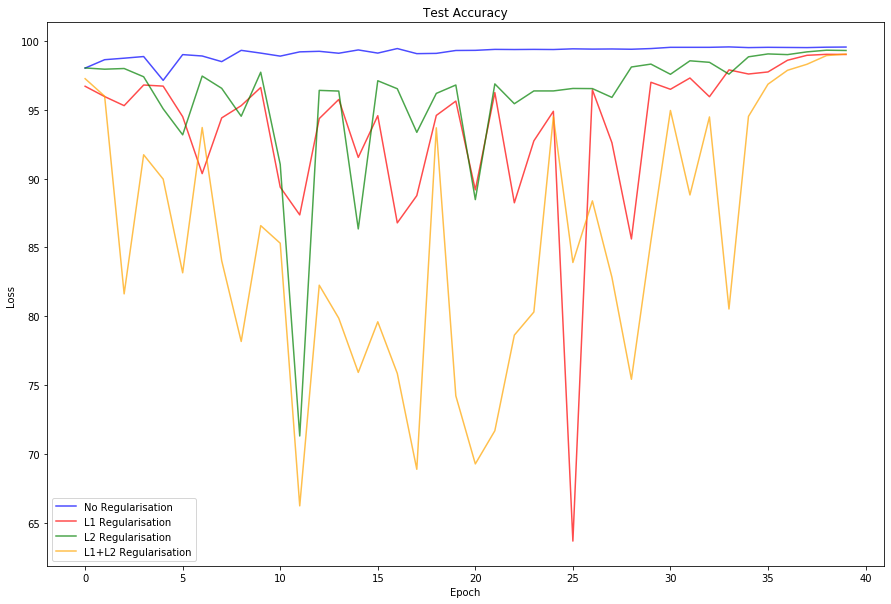

In [49]:
fig= plt.figure(figsize=(15,10))
ax= fig.add_subplot(1,1,1)
ax.plot(test_acc_1, color='blue',label='No Regularisation', alpha=0.7)
ax.plot(test_acc_l1, color='red',label='L1 Regularisation', alpha=0.7)
ax.plot(test_acc_l2, color='green',label='L2 Regularisation', alpha=0.7)
ax.plot(test_acc_l1l2, color='orange',label='L1+L2 Regularisation', alpha=0.7)
#ax.plot( train_acc, color='red',label='Train')
ax.legend()
#ax.set_ylim(96,100)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss ')
ax.set_title('Test Accuracy')
plt.savefig('Accuracy.png')

plt.show()

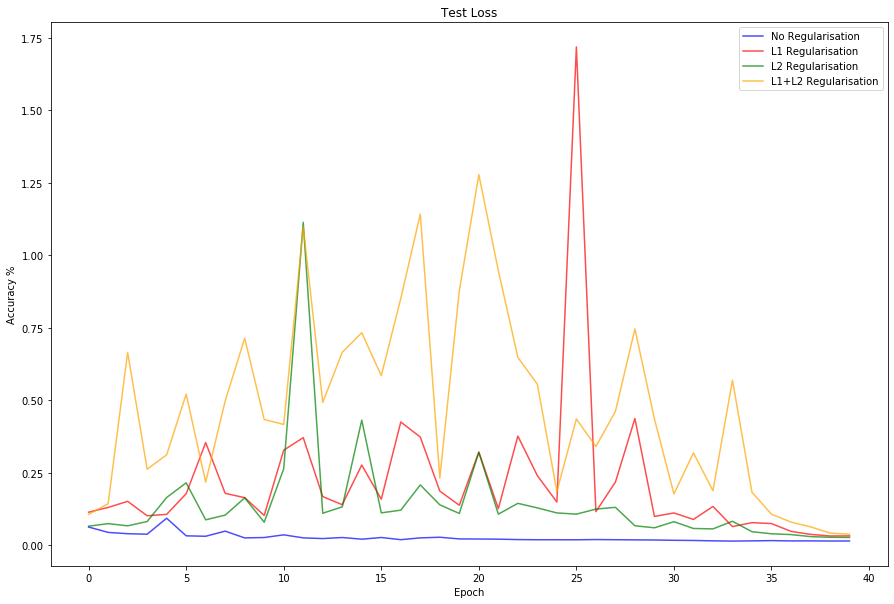

In [47]:
fig= plt.figure(figsize=(15,10))
ax2= fig.add_subplot(1,1,1)
ax2.plot(test_losses_1, color='blue', label='No Regularisation', alpha=0.7)
ax2.plot(test_losses_l1, color='red', label='L1 Regularisation', alpha=0.7)
ax2.plot(test_losses_l2, color='green', label='L2 Regularisation', alpha=0.7)
ax2.plot(test_losses_l1l2, color='orange', label='L1+L2 Regularisation', alpha=0.7)
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy %')
ax2.set_title('Test Loss')
plt.savefig('Loss.png')
plt.show()


In [0]:
model=None

In [35]:
use_cuda = torch.cuda.is_available()

cuda = torch.cuda.is_available()
correct = 0
total = 0
incorrect_examples=[]
incorrect_labels=[]
incorrect_preds=[]
for (i, [images, labels]) in enumerate(test_loader):
    images = (images.view(-1,1, 28,28)).to(device)
    outputs = model(images)
    _, predicted = torch.min(outputs.data, 1)
    total += labels.size(0)                    
    correct += (predicted == labels.to(device)).sum() 
    print('Accuracy: %d %%' % (100 * correct / total))

    # if (predicted==labels).item()==0:
    #     incorrect_examples.append(images.numpy())

    idxs_mask = (predicted == labels).view(-1)
    incorrect_examples.append(images[idxs_mask].numpy()) 
    incorrect_labels.append(labels[idxs_mask])
    incorrect_preds.append(predicted[idxs_mask])

Accuracy: 0 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


RuntimeError: ignored